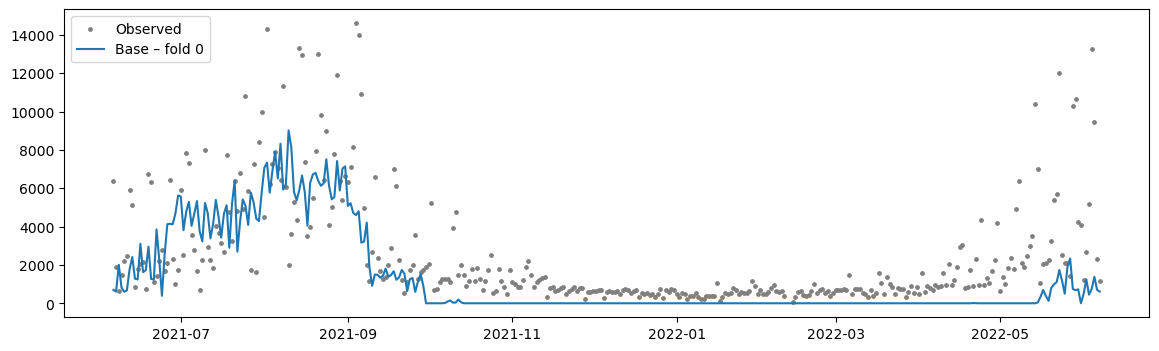

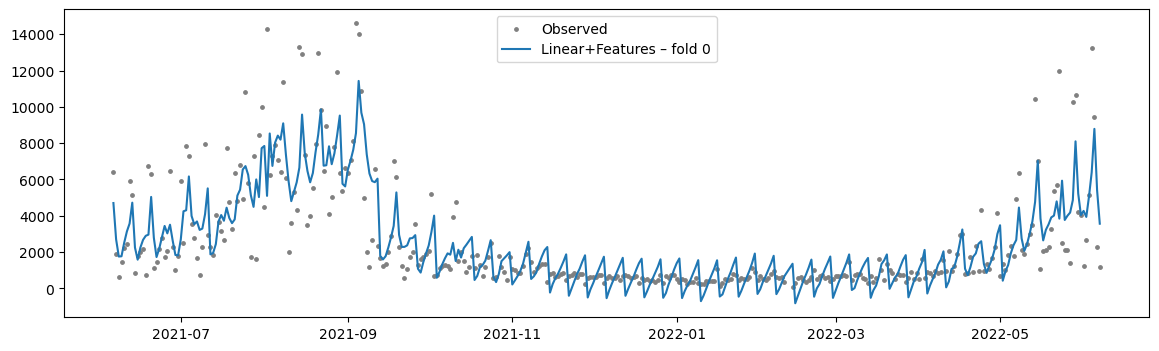

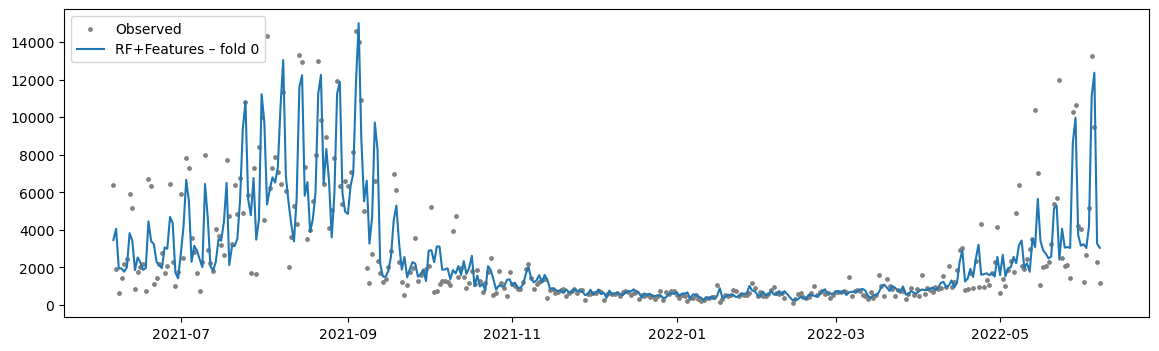

Bootstraps:   0%|          | 0/50 [00:00<?, ?it/s]

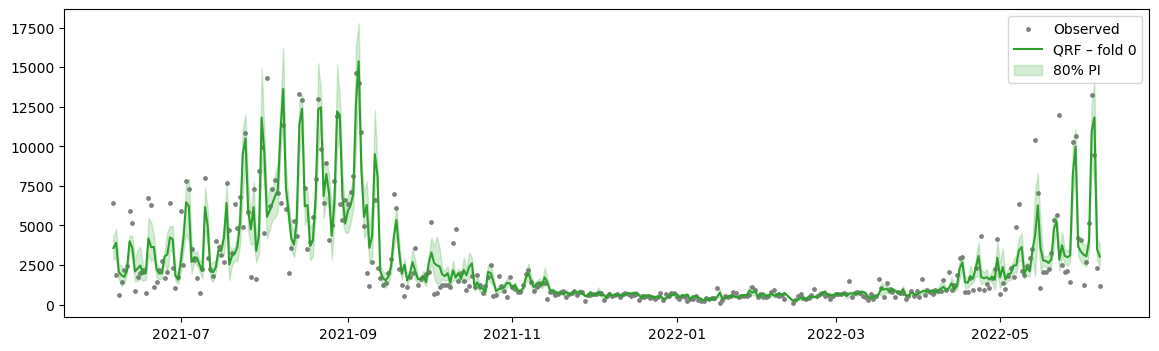

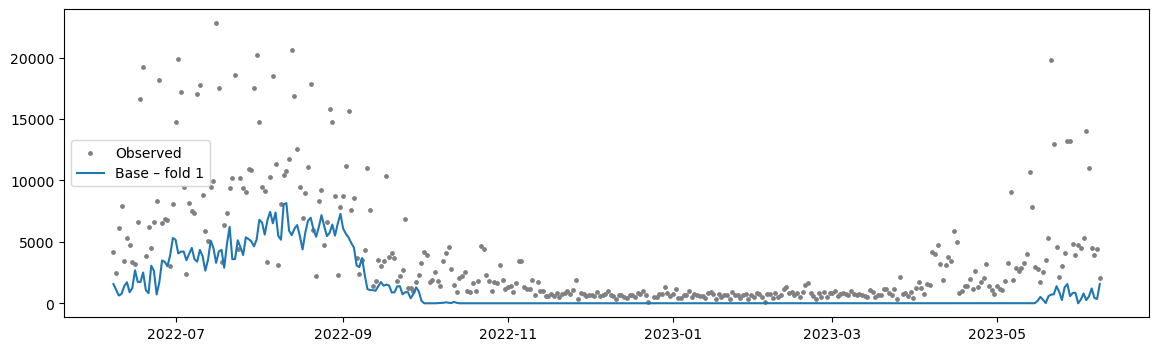

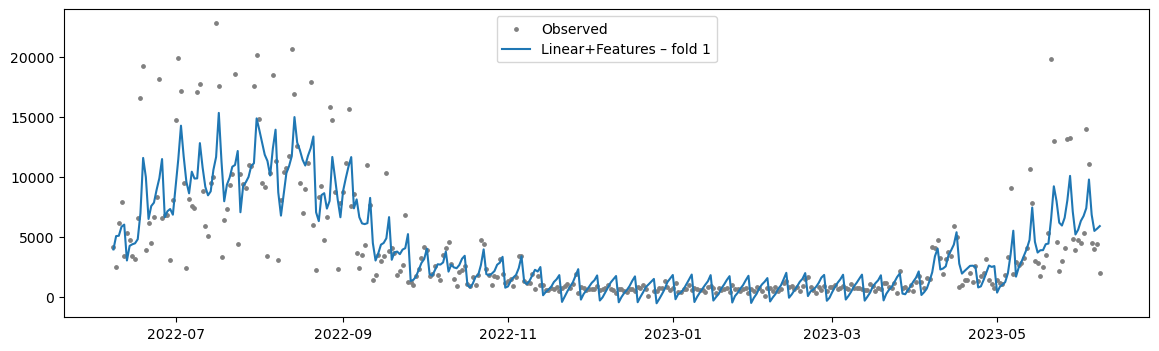

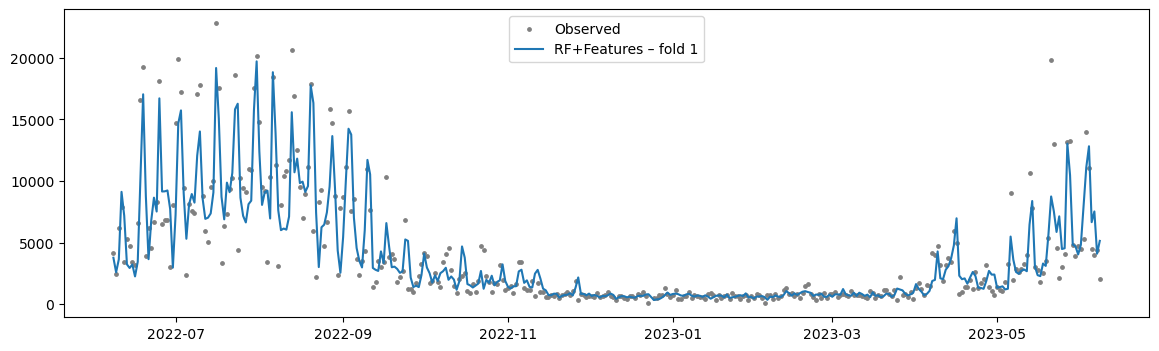

Bootstraps:   0%|          | 0/50 [00:00<?, ?it/s]

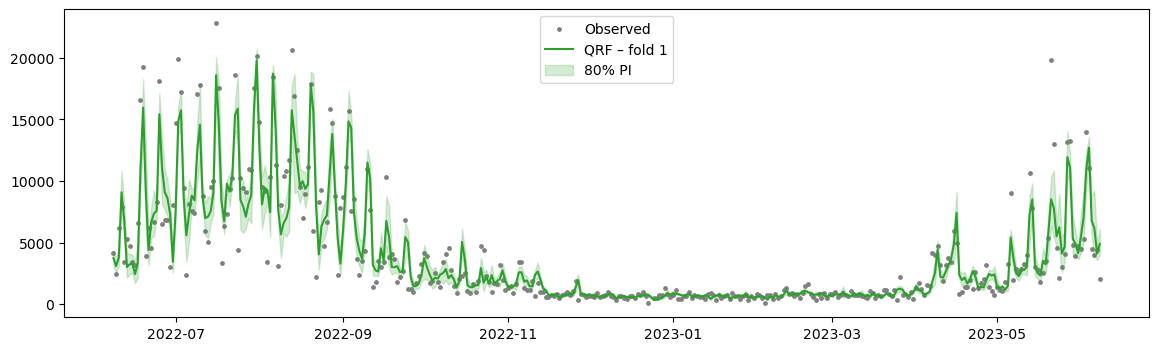

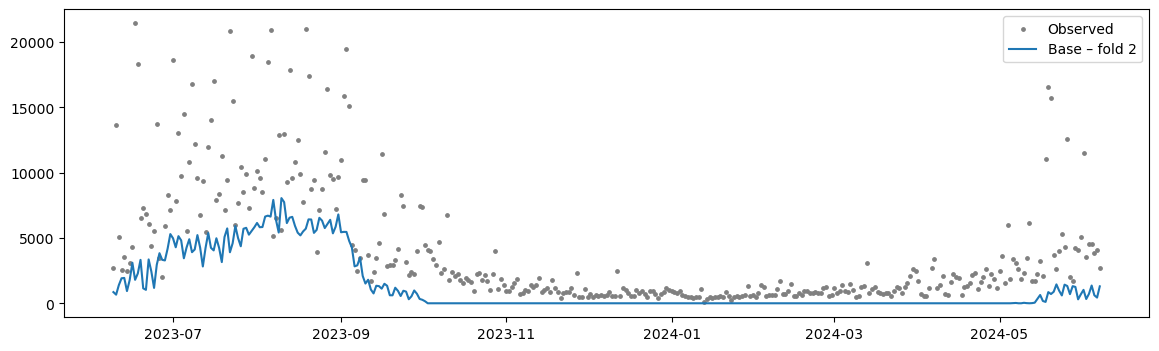

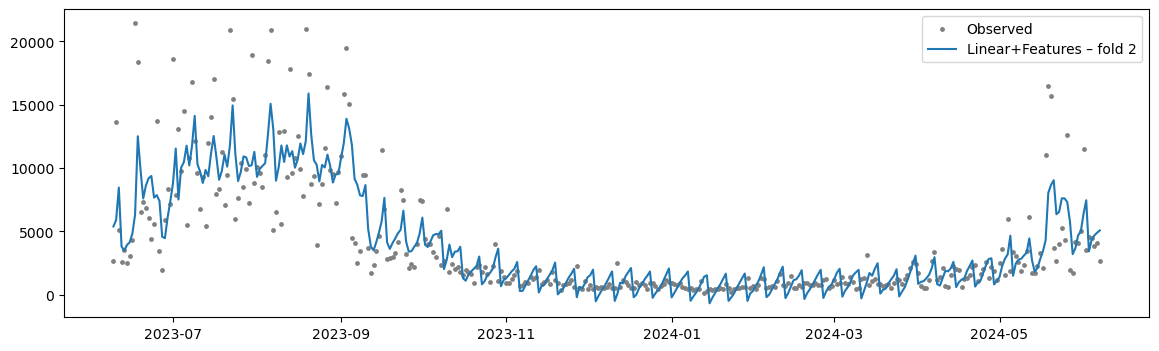

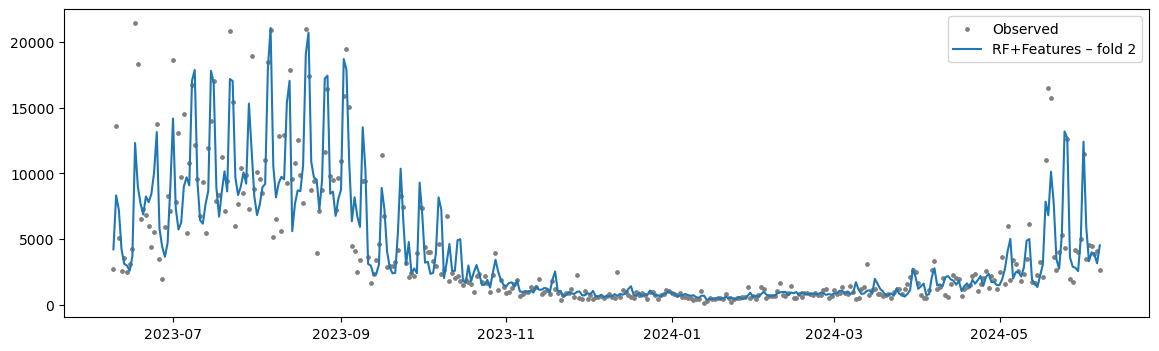

Bootstraps:   0%|          | 0/50 [00:00<?, ?it/s]

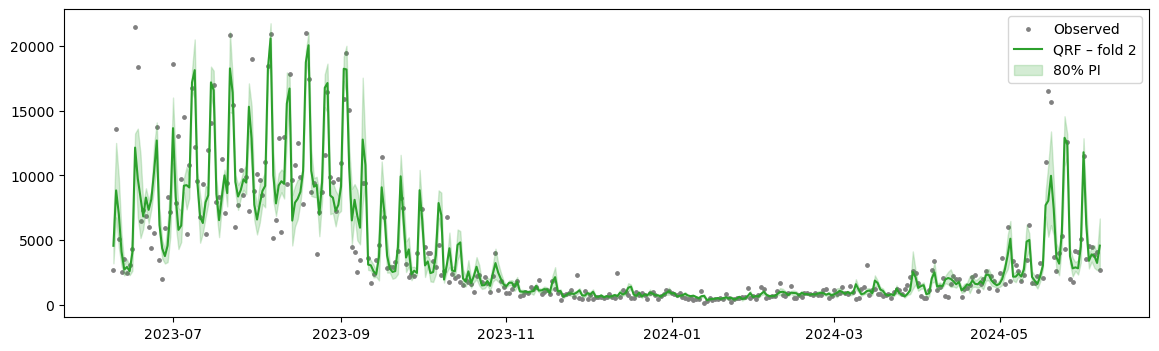

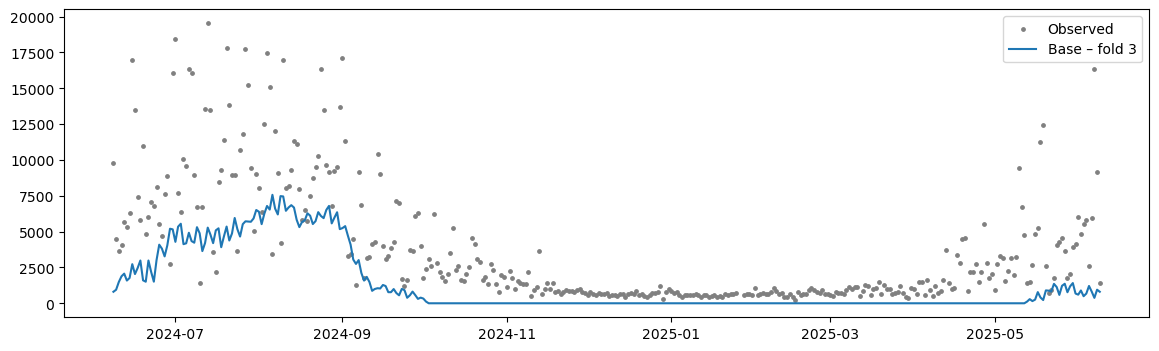

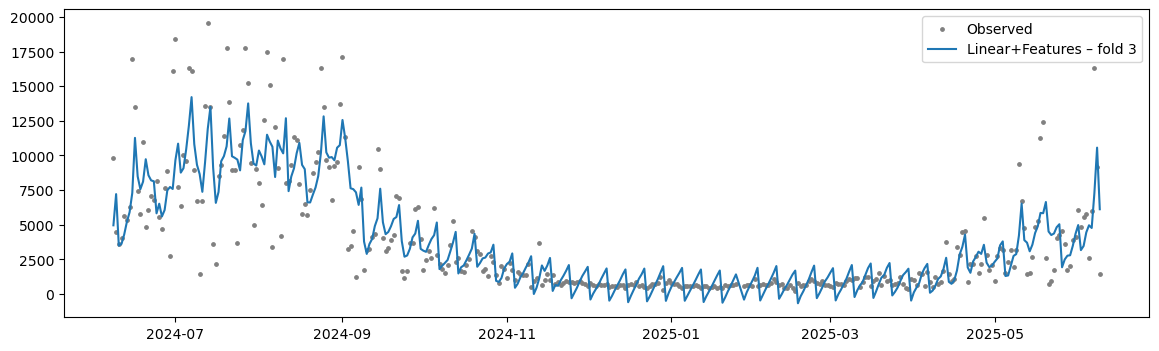

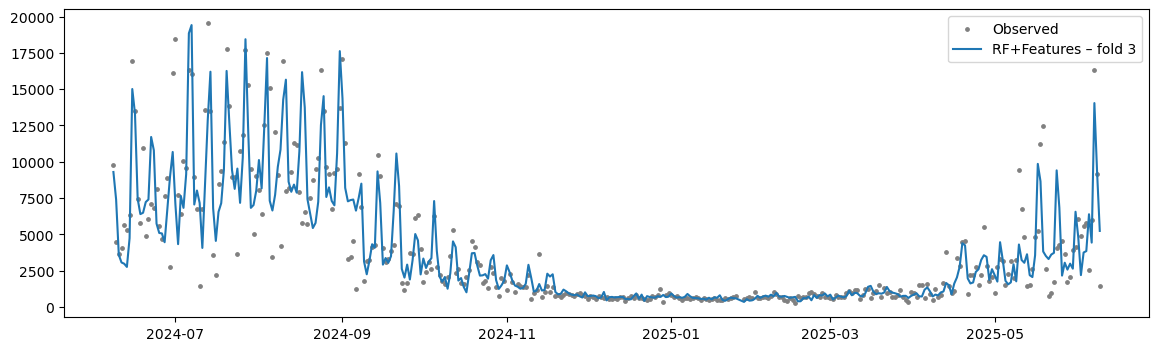

Bootstraps:   0%|          | 0/50 [00:00<?, ?it/s]

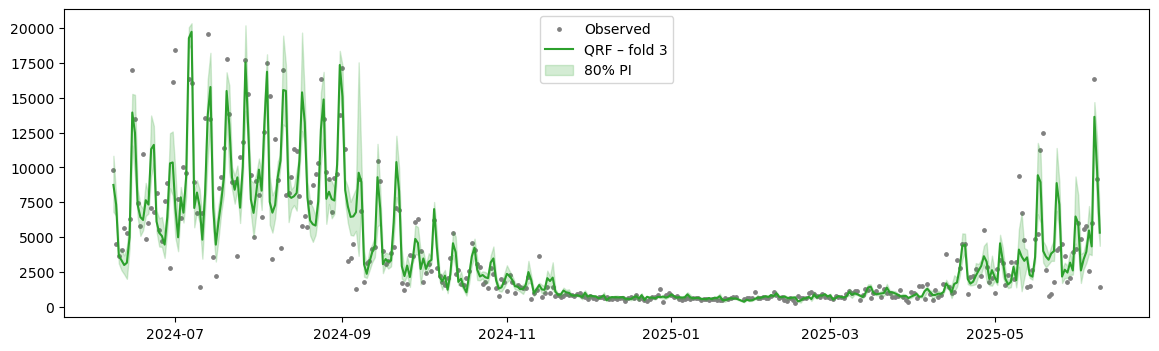

       Base  Linear+Features  RF+Features  \
0  0.858814         0.857710     0.425967   
1  0.846707         0.727097     0.414282   
2  0.840505         0.653844     0.381027   
3  0.842905         0.716886     0.377927   

                                                 QRF  
0  {'MAPE': 0.4190568271649407, 'cov': 0.37534246...  
1  {'MAPE': 0.40315118651354803, 'cov': 0.3506849...  
2  {'MAPE': 0.36813835847236737, 'cov': 0.3369863...  
3  {'MAPE': 0.3687329436060176, 'cov': 0.33698630...  


In [33]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.model_selection import TimeSeriesSplit
from sklearn.utils import resample
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

class RedemptionModel:
    def __init__(self, X: pd.DataFrame, target_col: str):
        self.X = X.copy()
        self.target_col = target_col
        self._add_time_features()
        self._add_lag_features(lag=1)
        self._add_rolling_mean(window=7)
        self.X.dropna(inplace=True)  # Drop any rows with missing feature values
        self.X = self.X[self.X[self.target_col] > 0]  # Remove rows with zero target
        self.results = {}

    def _add_time_features(self):
        idx = self.X.index
        self.X["month"] = idx.month
        self.X["quarter"] = idx.quarter
        self.X["dayofweek"] = idx.dayofweek

    def _add_lag_features(self, lag: int = 1):
        self.X[f"lag_{lag}"] = self.X[self.target_col].shift(lag)

    def _add_rolling_mean(self, window: int = 7):
        self.X[f"roll_mean_{window}"] = (
            self.X[self.target_col].rolling(window, min_periods=1).mean()
        )

    def safe_mape(self, truth: pd.Series, preds: pd.Series) -> float:
        """MAPE only where truth is not zero."""
        mask = truth != 0
        return MAPE(truth[mask], preds[mask])

    def run_models(self, n_splits: int = 4, test_size: int = 365,
                   b_boot: int = 50, q_lo: float = 0.10, q_hi: float = 0.90):
        tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size)
        features = ["dayofweek", "lag_1", "roll_mean_7"]

        for fold, (train_idx, test_idx) in enumerate(tscv.split(self.X)):
            train = self.X.iloc[train_idx]
            test = self.X.iloc[test_idx]

            # --- Base Model ---
            base_pred = self._base_model(train, test)
            self._store(fold, "Base", test[self.target_col], base_pred)
            self._plot(test.index, test[self.target_col], base_pred, label=f"Base – fold {fold}")

            # --- Linear Regression with features ---
            lr = LinearRegression()
            lr.fit(train[features], train[self.target_col])
            preds_lr = lr.predict(test[features])
            self._store(fold, "Linear+Features", test[self.target_col], preds_lr)
            self._plot(test.index, test[self.target_col], preds_lr, label=f"Linear+Features – fold {fold}")

            # --- Random Forest with features ---
            rf = RandomForestRegressor(n_estimators=100, random_state=fold)
            rf.fit(train[features], train[self.target_col])
            preds_rf = rf.predict(test[features])
            self._store(fold, "RF+Features", test[self.target_col], preds_rf)
            self._plot(test.index, test[self.target_col], preds_rf, label=f"RF+Features – fold {fold}")

            # --- QRF Bootstrapped Intervals (for the same features) ---
            qdf = self._bootstrap_rf_model(train, test, features=features,
                                           b_boot=b_boot, q_lo=q_lo, q_hi=q_hi)
            self._store_interval(fold, "QRF", test[self.target_col], qdf)
            self._plot_interval(test.index, test[self.target_col], qdf, label=f"QRF – fold {fold}")

    def _base_model(self, train: pd.DataFrame, test: pd.DataFrame) -> pd.Series:
        res = sm.tsa.seasonal_decompose(train[self.target_col], period=365)
        res_clip = res.seasonal.clip(lower=0)
        res_clip.index = res_clip.index.dayofyear
        avg_season = res_clip.groupby(res_clip.index).mean().to_dict()
        return pd.Series(index=test.index,
                         data=[avg_season.get(idx.dayofyear, 0)
                               for idx in test.index])

    def _bootstrap_rf_model(self, train: pd.DataFrame, test: pd.DataFrame,
                            features=None, b_boot: int = 50, q_lo: float = 0.10,
                            q_hi: float = 0.90) -> pd.DataFrame:
        if features is None:
            features = [c for c in train.columns if c not in [self.target_col]]

        y_train = train[self.target_col]
        preds = np.zeros((b_boot, len(test)))
        for b in tqdm(range(b_boot), desc="Bootstraps", leave=False):
            boot_idx = resample(train.index, replace=True)
            Xb = train.loc[boot_idx, features]
            yb = y_train.loc[boot_idx]
            rf = RandomForestRegressor(
                n_estimators=100,
                max_depth=None,
                random_state=b,
                n_jobs=-1,
            )
            rf.fit(Xb, yb)
            preds[b] = rf.predict(test[features])
        y_hat = preds.mean(axis=0)
        lo = np.quantile(preds, q_lo, axis=0)
        hi = np.quantile(preds, q_hi, axis=0)
        return pd.DataFrame({
            "pred": y_hat,
            "lo": lo,
            "hi": hi
        }, index=test.index)

    def _store(self, fold, model_name, truth, pred):
        mape = self.safe_mape(truth, pd.Series(pred, index=truth.index))
        self.results.setdefault(model_name, {})[fold] = mape

    def _store_interval(self, fold, model_name, truth, qdf):
        mape = self.safe_mape(truth, qdf["pred"])
        coverage = ((truth >= qdf["lo"]) & (truth <= qdf["hi"])).mean()
        width = (qdf["hi"] - qdf["lo"]).mean()
        self.results.setdefault(model_name, {})[fold] = {
            "MAPE": mape,
            "cov": coverage,
            "w": width,
        }

    def _plot(self, idx, truth, pred, label=""):
        fig, ax = plt.subplots(figsize=(14, 4))
        ax.scatter(idx, truth, s=6, color="grey", label="Observed")
        ax.plot(idx, pred, label=label)
        ax.legend(); plt.show()

    def _plot_interval(self, idx, truth, qdf, label=""):
        fig, ax = plt.subplots(figsize=(14, 4))
        ax.scatter(idx, truth, s=6, color="grey", label="Observed")
        ax.plot(idx, qdf["pred"], color="C2", label=label)
        ax.fill_between(idx, qdf["lo"], qdf["hi"], color="C2", alpha=0.2,
                        label="80% PI")
        ax.legend(); plt.show()

def load_data(file: str) -> pd.DataFrame:
    df = (
        pd.read_csv(
            file,
            dtype={"_id": int, "Redemption Count": int, "Sales Count": int},
            parse_dates=["Timestamp"],
        )
        .sort_values("Timestamp")
        .set_index("Timestamp")
        .resample("1D")
        .sum()
    )
    return df

if __name__ == "__main__":
    data = load_data("Toronto Island Ferry Ticket Counts.csv")
    model = RedemptionModel(data, "Redemption Count")
    model.run_models()
    print(pd.DataFrame(model.results))


Rows before filtering: 3692, after filtering: 3682
            Sales Count   lag_1  roll_mean_7  dayofweek
Timestamp                                              
2015-05-05          549    75.0   125.600000          1
2015-05-06         1358   549.0   331.000000          2
2015-05-07         2170  1358.0   593.714286          3
2015-05-08         3390  2170.0  1077.428571          4
2015-05-09         6145  3390.0  1955.285714          5
2015-05-10         3554  6145.0  2463.000000          6
2015-05-11          908  3554.0  2582.000000          0
2015-05-12         3631   908.0  3022.285714          1
2015-05-13         1181  3631.0  2997.000000          2
2015-05-14         2563  1181.0  3053.142857          3
Number of zeros in target: 0

=== Fold 0 ===
Train size: 2222, Test size: 365
Train date range: 2015-05-05 00:00:00 to 2021-06-08 00:00:00
Test date range: 2021-06-09 00:00:00 to 2022-06-08 00:00:00
Train min/max Sales: 3 / 25585
Test min/max Sales: 2 / 12459
Train min/max lag

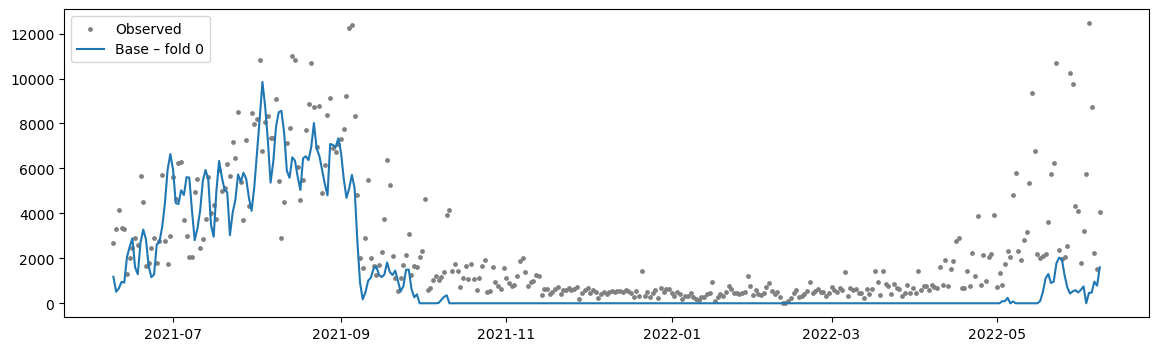

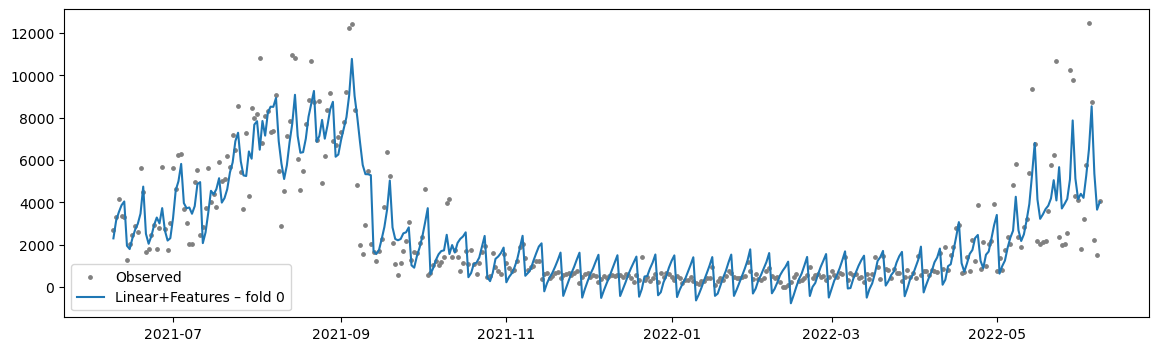

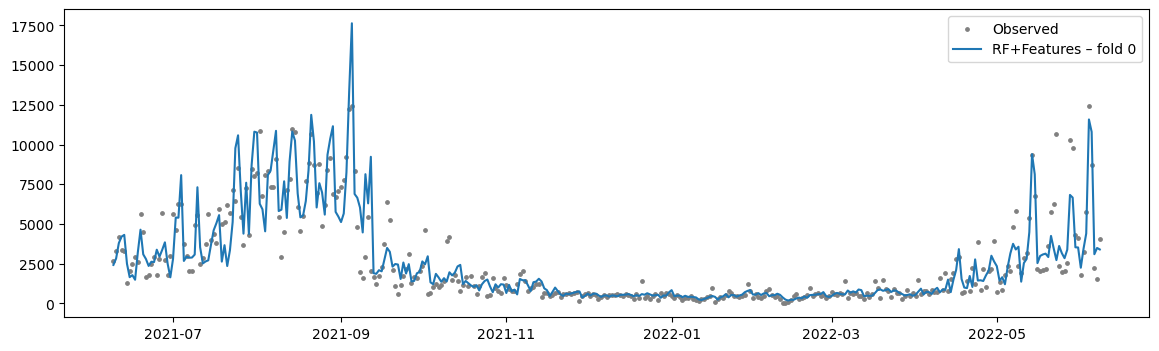

Bootstraps:   0%|          | 0/50 [00:00<?, ?it/s]

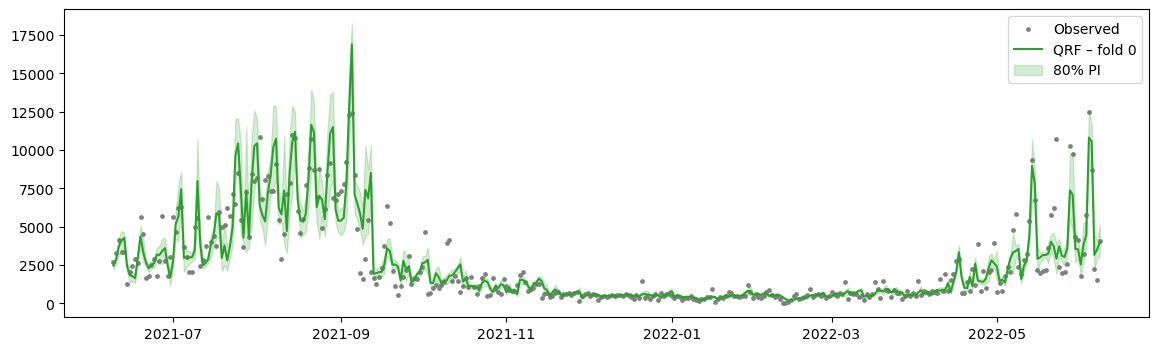

Sample predictions (actual vs. models):
   actual         Base           LR       RF        QRF
0    2683  1179.260829  2298.318583  2418.78  2461.0170
1    3296   513.662747  3134.407086  2828.53  2873.5064
2    4157   661.281560  3534.272329  3791.17  3728.9826
3    3338   949.369688  3863.422871  4199.34  4099.2206
4    3317   920.985304  4041.267402  4310.38  4271.7436

=== Fold 1 ===
Train size: 2587, Test size: 365
Train date range: 2015-05-05 00:00:00 to 2022-06-08 00:00:00
Test date range: 2022-06-09 00:00:00 to 2023-06-08 00:00:00
Train min/max Sales: 2 / 25585
Test min/max Sales: 36 / 20498
Train min/max lag_1: 2.0 / 25585.0
Test min/max lag_1: 36.0 / 20498.0
Train min/max roll_mean_7: 68.0 / 16240.857142857143
Test min/max roll_mean_7: 406.0 / 13289.57142857143


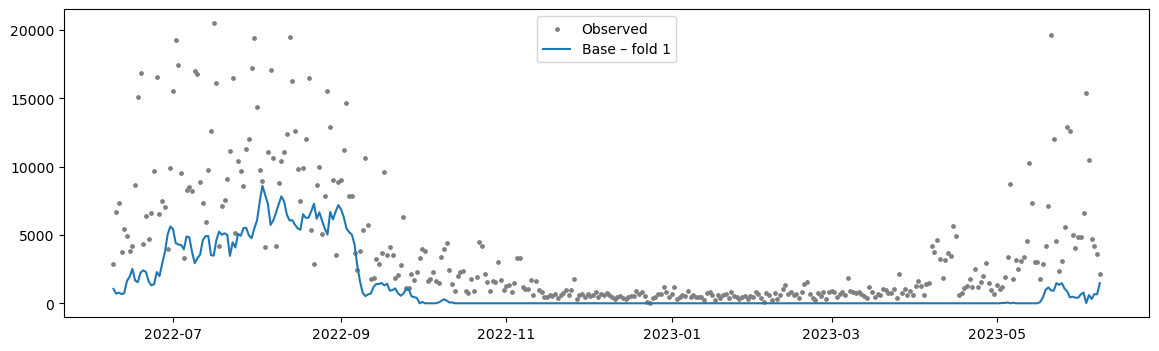

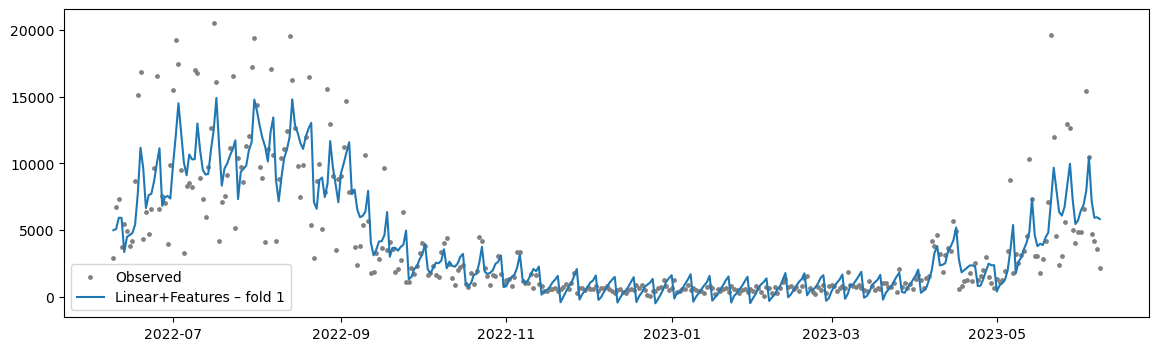

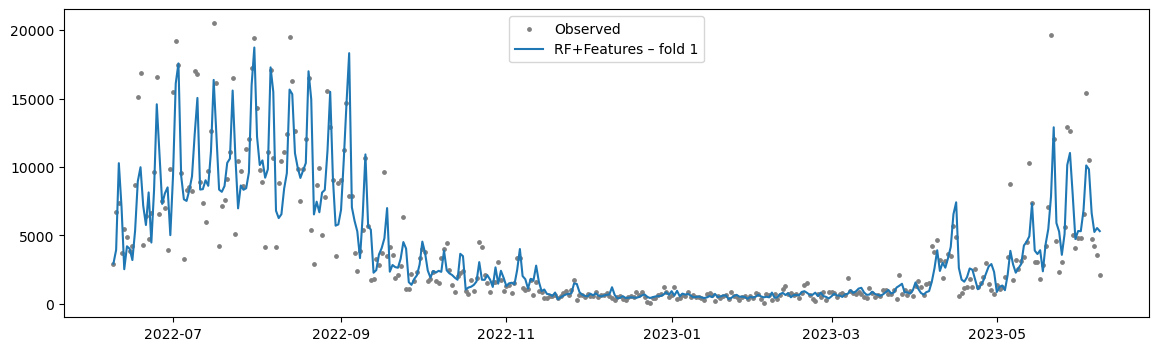

Bootstraps:   0%|          | 0/50 [00:00<?, ?it/s]

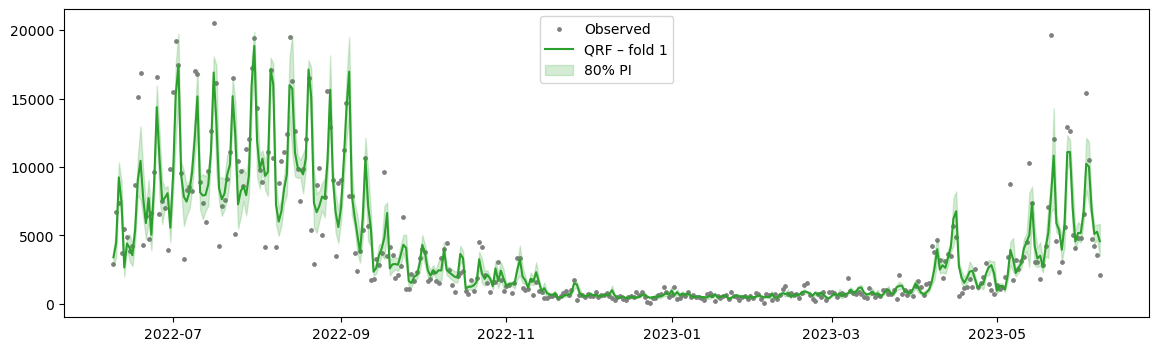

Sample predictions (actual vs. models):
   actual         Base           LR        RF        QRF
0    2883  1056.552600  4987.182632   2934.08  3392.4856
1    6695   705.864900  5076.499383   3930.99  4423.4890
2    7353   780.523478  5923.510508  10274.53  9234.4030
3    3720   668.369532  5909.542626   7057.74  7388.0394
4    5467   748.857464  3347.812882   2524.70  2657.7624

=== Fold 2 ===
Train size: 2952, Test size: 365
Train date range: 2015-05-05 00:00:00 to 2023-06-08 00:00:00
Test date range: 2023-06-09 00:00:00 to 2024-06-07 00:00:00
Train min/max Sales: 2 / 25585
Test min/max Sales: 86 / 20234
Train min/max lag_1: 2.0 / 25585.0
Test min/max lag_1: 86.0 / 20234.0
Train min/max roll_mean_7: 68.0 / 16240.857142857143
Test min/max roll_mean_7: 286.42857142857144 / 12816.42857142857


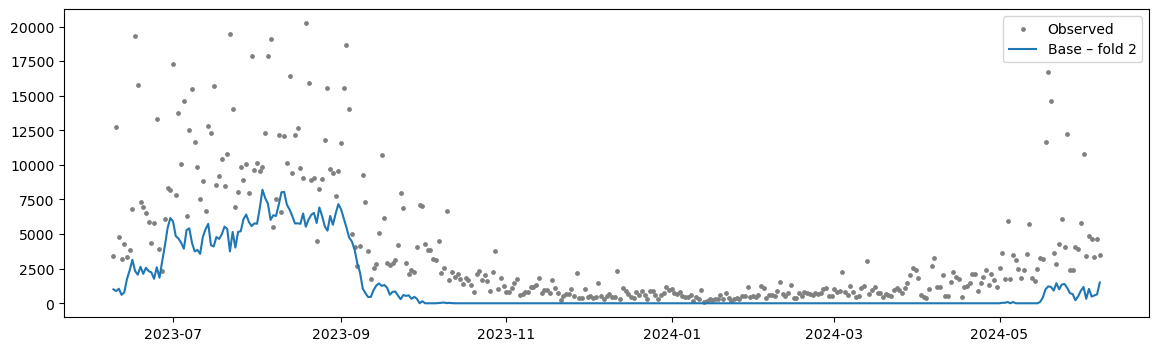

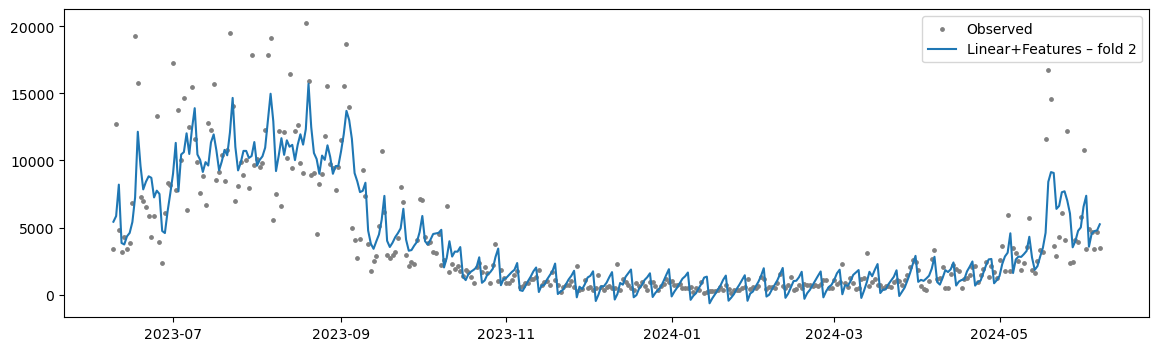

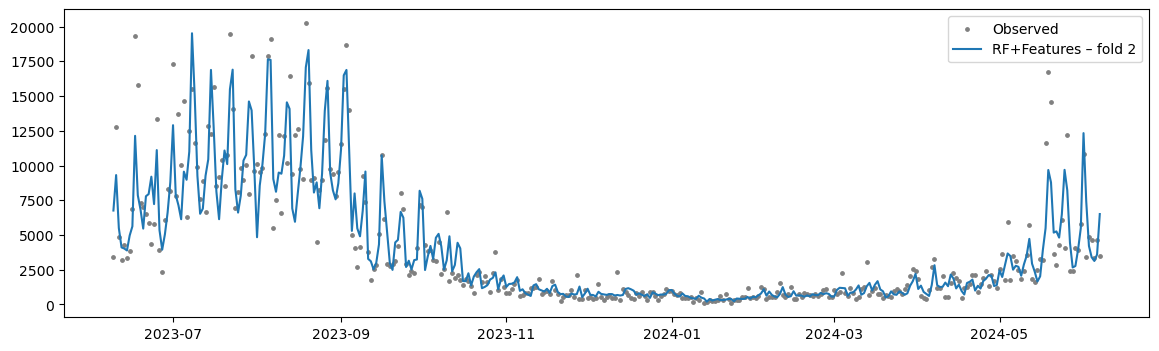

Bootstraps:   0%|          | 0/50 [00:00<?, ?it/s]

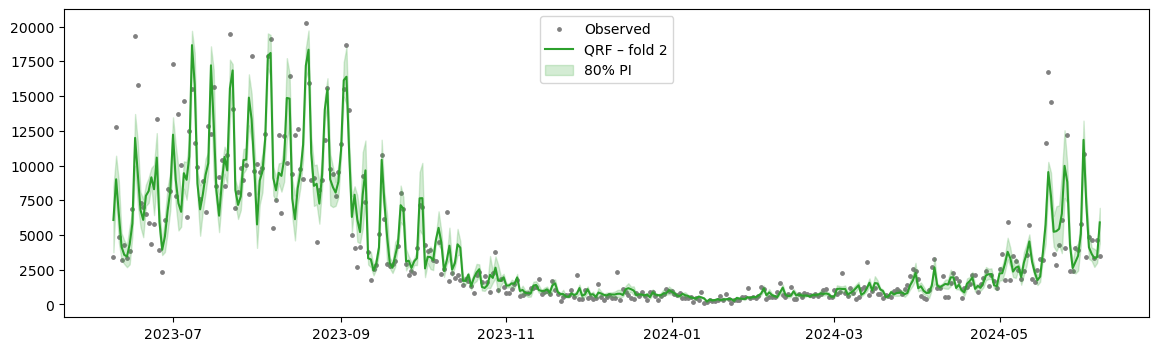

Sample predictions (actual vs. models):
   actual         Base           LR       RF        QRF
0    3421  1007.631070  5430.115901  6759.02  6077.4448
1   12749   879.402173  5850.518130  9311.46  9008.7562
2    4820  1050.526244  8197.741482  5496.34  6521.3448
3    3201   610.976978  3846.311266  4105.07  4153.0444
4    4263   782.568171  3733.859254  4026.11  3570.4708

=== Fold 3 ===
Train size: 3317, Test size: 365
Train date range: 2015-05-05 00:00:00 to 2024-06-07 00:00:00
Test date range: 2024-06-08 00:00:00 to 2025-06-09 00:00:00
Train min/max Sales: 2 / 25585
Test min/max Sales: 232 / 19681
Train min/max lag_1: 2.0 / 25585.0
Test min/max lag_1: 4.0 / 19681.0
Train min/max roll_mean_7: 68.0 / 16240.857142857143
Test min/max roll_mean_7: 388.0 / 12175.714285714286


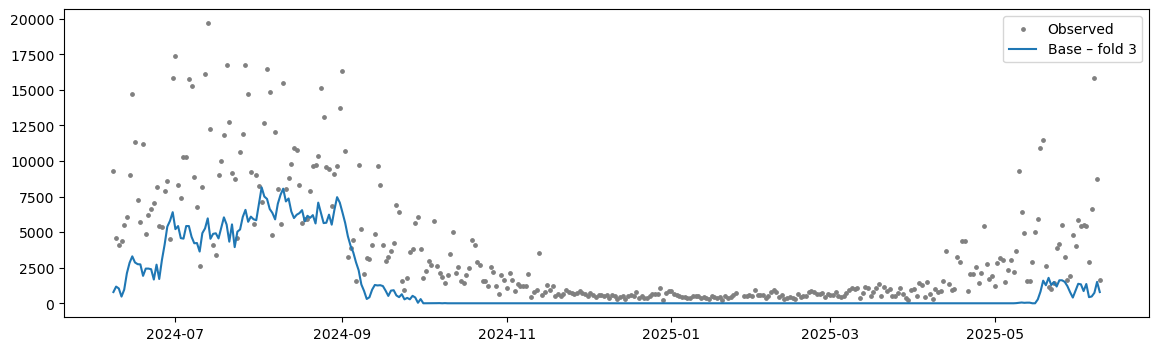

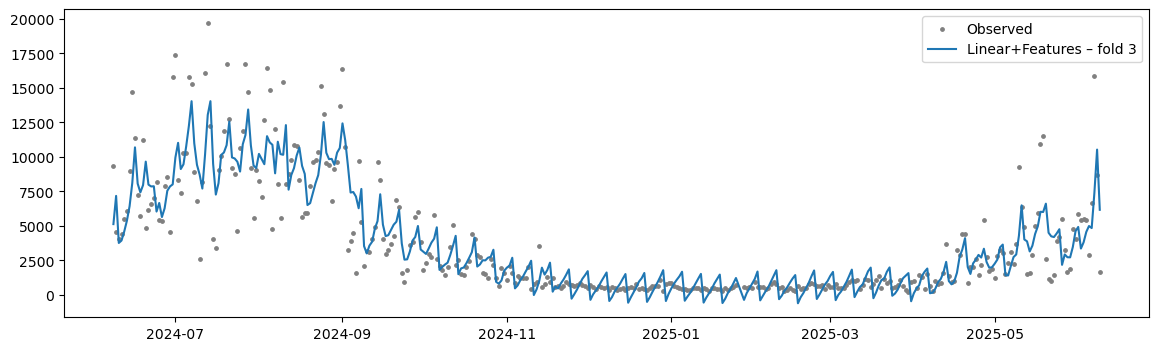

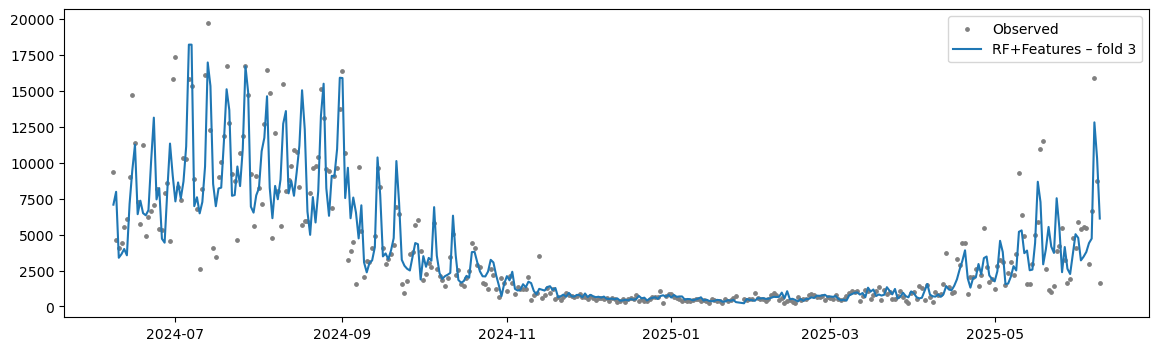

Bootstraps:   0%|          | 0/50 [00:00<?, ?it/s]

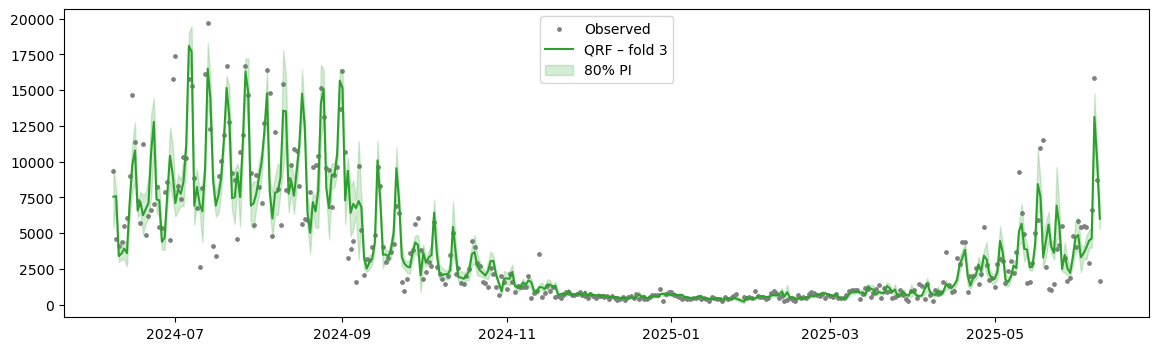

Sample predictions (actual vs. models):
   actual         Base           LR       RF        QRF
0    9330   788.998407  5125.721689  7075.64  7547.5478
1    4586  1173.752235  7171.301474  7967.88  7594.9524
2    4072  1040.504594  3760.199084  3384.91  3397.8146
3    4387   470.721603  3935.774729  3639.70  3577.0542
4    5502   958.235872  4581.592370  3996.18  3923.4648

Summary Table:
       Base  Linear+Features  RF+Features  \
0  0.804452         2.209984     0.990573   
1  0.849566         0.780704     0.449005   
2  0.845246         0.665764     0.383085   
3  0.833636         0.696238     0.383597   

                                                 QRF  
0  {'MAPE': 1.0447534783568733, 'cov': 0.37808219...  
1  {'MAPE': 0.442458954751945, 'cov': 0.367123287...  
2  {'MAPE': 0.38015928156289847, 'cov': 0.3835616...  
3  {'MAPE': 0.3753439637379517, 'cov': 0.33424657...  


In [44]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.model_selection import TimeSeriesSplit
from sklearn.utils import resample
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

class SalesForecastModel:
    def __init__(self, X: pd.DataFrame, target_col: str):
        self.X = X.copy()
        self.target_col = target_col

        # Feature Engineering
        self.X['dayofweek'] = self.X.index.dayofweek
        self.X['lag_1'] = self.X[self.target_col].shift(1)
        self.X['roll_mean_7'] = self.X[self.target_col].rolling(7, min_periods=1).mean()
        # Drop missing values
        self.X.dropna(inplace=True)
        # Drop rows with zero sales, lag, or rolling mean
        before = self.X.shape[0]
        self.X = self.X[
            (self.X[self.target_col] > 0) &
            (self.X['lag_1'] > 0) &
            (self.X['roll_mean_7'] > 0)
        ]
        after = self.X.shape[0]
        print(f"Rows before filtering: {before}, after filtering: {after}")
        print(self.X[[self.target_col, 'lag_1', 'roll_mean_7', 'dayofweek']].head(10))
        print(f"Number of zeros in target: {(self.X[self.target_col] == 0).sum()}")
        self.results = {}

    def safe_mape(self, truth: pd.Series, preds: pd.Series) -> float:
        mask = truth != 0
        return MAPE(truth[mask], preds[mask])

    def run_models(self, n_splits: int = 4, test_size: int = 365,
                   b_boot: int = 50, q_lo: float = 0.10, q_hi: float = 0.90):
        tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size)
        features = ["dayofweek", "lag_1", "roll_mean_7"]

        for fold, (train_idx, test_idx) in enumerate(tscv.split(self.X)):
            train = self.X.iloc[train_idx]
            test = self.X.iloc[test_idx]

            print(f"\n=== Fold {fold} ===")
            print(f"Train size: {len(train)}, Test size: {len(test)}")
            print(f"Train date range: {train.index.min()} to {train.index.max()}")
            print(f"Test date range: {test.index.min()} to {test.index.max()}")
            print(f"Train min/max Sales: {train[self.target_col].min()} / {train[self.target_col].max()}")
            print(f"Test min/max Sales: {test[self.target_col].min()} / {test[self.target_col].max()}")
            print(f"Train min/max lag_1: {train['lag_1'].min()} / {train['lag_1'].max()}")
            print(f"Test min/max lag_1: {test['lag_1'].min()} / {test['lag_1'].max()}")
            print(f"Train min/max roll_mean_7: {train['roll_mean_7'].min()} / {train['roll_mean_7'].max()}")
            print(f"Test min/max roll_mean_7: {test['roll_mean_7'].min()} / {test['roll_mean_7'].max()}")

            # --- Base Model ---
            base_pred = self._base_model(train, test)
            self._store(fold, "Base", test[self.target_col], base_pred)
            self._plot(test.index, test[self.target_col], base_pred, label=f"Base – fold {fold}")

            # --- Linear Regression with features ---
            lr = LinearRegression()
            lr.fit(train[features], train[self.target_col])
            preds_lr = lr.predict(test[features])
            self._store(fold, "Linear+Features", test[self.target_col], preds_lr)
            self._plot(test.index, test[self.target_col], preds_lr, label=f"Linear+Features – fold {fold}")

            # --- Random Forest with features ---
            rf = RandomForestRegressor(n_estimators=100, random_state=fold)
            rf.fit(train[features], train[self.target_col])
            preds_rf = rf.predict(test[features])
            self._store(fold, "RF+Features", test[self.target_col], preds_rf)
            self._plot(test.index, test[self.target_col], preds_rf, label=f"RF+Features – fold {fold}")

            # --- QRF Bootstrapped Intervals ---
            qdf = self._bootstrap_rf_model(train, test, features=features,
                                           b_boot=b_boot, q_lo=q_lo, q_hi=q_hi)
            self._store_interval(fold, "QRF", test[self.target_col], qdf)
            self._plot_interval(test.index, test[self.target_col], qdf, label=f"QRF – fold {fold}")

            print("Sample predictions (actual vs. models):")
            print(pd.DataFrame({
                "actual": test[self.target_col].values[:5],
                "Base": base_pred.values[:5],
                "LR": preds_lr[:5],
                "RF": preds_rf[:5],
                "QRF": qdf['pred'].values[:5],
            }))

    def _base_model(self, train: pd.DataFrame, test: pd.DataFrame) -> pd.Series:
        res = sm.tsa.seasonal_decompose(train[self.target_col], period=365)
        res_clip = res.seasonal.clip(lower=0)
        res_clip.index = res_clip.index.dayofyear
        avg_season = res_clip.groupby(res_clip.index).mean().to_dict()
        return pd.Series(index=test.index,
                         data=[avg_season.get(idx.dayofyear, 0)
                               for idx in test.index])

    def _bootstrap_rf_model(self, train: pd.DataFrame, test: pd.DataFrame,
                            features=None, b_boot: int = 50, q_lo: float = 0.10,
                            q_hi: float = 0.90) -> pd.DataFrame:
        if features is None:
            features = [c for c in train.columns if c not in [self.target_col]]

        y_train = train[self.target_col]
        preds = np.zeros((b_boot, len(test)))
        for b in tqdm(range(b_boot), desc="Bootstraps", leave=False):
            boot_idx = resample(train.index, replace=True)
            Xb = train.loc[boot_idx, features]
            yb = y_train.loc[boot_idx]
            rf = RandomForestRegressor(
                n_estimators=100,
                max_depth=None,
                random_state=b,
                n_jobs=-1,
            )
            rf.fit(Xb, yb)
            preds[b] = rf.predict(test[features])
        y_hat = preds.mean(axis=0)
        lo = np.quantile(preds, q_lo, axis=0)
        hi = np.quantile(preds, q_hi, axis=0)
        return pd.DataFrame({
            "pred": y_hat,
            "lo": lo,
            "hi": hi
        }, index=test.index)

    def _store(self, fold, model_name, truth, pred):
        mape = self.safe_mape(truth, pd.Series(pred, index=truth.index))
        self.results.setdefault(model_name, {})[fold] = mape

    def _store_interval(self, fold, model_name, truth, qdf):
        mape = self.safe_mape(truth, qdf["pred"])
        coverage = ((truth >= qdf["lo"]) & (truth <= qdf["hi"])).mean()
        width = (qdf["hi"] - qdf["lo"]).mean()
        self.results.setdefault(model_name, {})[fold] = {
            "MAPE": mape,
            "cov": coverage,
            "w": width,
        }

    def _plot(self, idx, truth, pred, label=""):
        fig, ax = plt.subplots(figsize=(14, 4))
        ax.scatter(idx, truth, s=6, color="grey", label="Observed")
        ax.plot(idx, pred, label=label)
        ax.legend(); plt.show()

    def _plot_interval(self, idx, truth, qdf, label=""):
        fig, ax = plt.subplots(figsize=(14, 4))
        ax.scatter(idx, truth, s=6, color="grey", label="Observed")
        ax.plot(idx, qdf["pred"], color="C2", label=label)
        ax.fill_between(idx, qdf["lo"], qdf["hi"], color="C2", alpha=0.2,
                        label="80% PI")
        ax.legend(); plt.show()

def load_data(file: str) -> pd.DataFrame:
    df = (
        pd.read_csv(
            file,
            dtype={"_id": int, "Redemption Count": int, "Sales Count": int},
            parse_dates=["Timestamp"],
        )
        .sort_values("Timestamp")
        .set_index("Timestamp")
        .resample("1D")
        .sum()
    )
    return df

if __name__ == "__main__":
    data = load_data("Toronto Island Ferry Ticket Counts.csv")
    model = SalesForecastModel(data, "Sales Count")
    model.run_models()
    print("\nSummary Table:")
    print(pd.DataFrame(model.results))

